# Logistic Regression Notebook

### Absenteeism at Work Analysis

Notebook 2/3 

Now that we have finished preprocessing our data, we can move on to our analysis.

We will be creating a logistic regression model which will predict the absenteeism of an individual based on the various features we have available in our dataset.

Starting off with importing the required libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import pickle

Read in the data that we preprocessed earlier

In [3]:
df = pd.read_csv('absenteeism_Preprocessed.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Reason_1                   700 non-null    int64  
 1   Reason_2                   700 non-null    int64  
 2   Reason_3                   700 non-null    int64  
 3   Reason_4                   700 non-null    int64  
 4   Month Value                700 non-null    int64  
 5   Day of the Week            700 non-null    int64  
 6   Transportation Expense     700 non-null    int64  
 7   Distance to Work           700 non-null    int64  
 8   Age                        700 non-null    int64  
 9   Daily Work Load Average    700 non-null    float64
 10  Body Mass Index            700 non-null    int64  
 11  Education                  700 non-null    int64  
 12  Children                   700 non-null    int64  
 13  Pets                       700 non-null    int64  

In [5]:
df.head(3)

,Reason_1,Reason_2,Reason_3,Reason_4,Month Value,Day of the Week,Transportation Expense,Distance to Work,Age,Daily Work Load Average,Body Mass Index,Education,Children,Pets,Absenteeism Time in Hours
0,0,0,0,1,7,1,289,36,33,239.554,30,0,2,1,4
1,0,0,0,0,7,1,118,13,50,239.554,31,0,1,0,0
2,0,0,0,1,7,2,179,51,38,239.554,31,0,0,0,2


We can now start to analyze the data.

We may predict that some of the columns may be more greatly correlated with 'Absenteeism Time in Hours' than other columns.  
The 'Reasons_1-4' may be the most predictive of absenteeism time, while 'Pets' may not be so greatly correlated. 

As a refresher, these are the four categories in Reasons_1-4:
* 1-14: related to various diseases
* 15-17: related to pregnancy or giving birth
* 18-21: related to poisonings or symptoms not otherwise classified
* 22-28: 'light reasons' such as a doctor's appointment


We can observe these relationships using logistic regression. 

First off, we can find the median absenteeism time to get a sense of what might be considered to be abnormally high or low absenteeism times.

In [6]:
df['Absenteeism Time in Hours'].median()

3.0

We can see that the median time absent is about 3 hours.  
With this, we can suggest that an individual spending <=3 hours away is moderately absent, and and individual spending >3 hours away is excessively absent.

Furthering this idea, we can modify the 'Absenteeism Time in Hours' column to be a binary variable, with 0 = moderately absent and 1 = excessively absent.

In [7]:
df['Excessive Absenteeism'] = df['Absenteeism Time in Hours'].apply(lambda x: 1 if x > df['Absenteeism Time in Hours'].median() else 0)

In [8]:
df['Excessive Absenteeism'].value_counts()

0    381
1    319
Name: Excessive Absenteeism, dtype: int64

In [9]:
df['Excessive Absenteeism'].sum() / len(df)

0.45571428571428574

We can see that about 46% of the values are 1s, implying just under half of the individuals are excessively absent.  
This makes sense as we used the median to designate the point of extreme absenteeism.

### Checkpoint 1:

We no longer need the 'Absenteeism Time in Hours' column, so we can drop it while also creating a checkpoint. 

In [10]:
df_targets = df.drop(columns=['Absenteeism Time in Hours'])

In [11]:
df_targets.head(3)

,Reason_1,Reason_2,Reason_3,Reason_4,Month Value,Day of the Week,Transportation Expense,Distance to Work,Age,Daily Work Load Average,Body Mass Index,Education,Children,Pets,Excessive Absenteeism
0,0,0,0,1,7,1,289,36,33,239.554,30,0,2,1,1
1,0,0,0,0,7,1,118,13,50,239.554,31,0,1,0,0
2,0,0,0,1,7,2,179,51,38,239.554,31,0,0,0,0


We can isolate the dataframe without the 'Excessive Absenteeism' column so that we can predict it with our logistic regression model once it is created.

In [12]:
unscaled_inputs = df_targets.iloc[:, :-1]

Custom class to use StandardScaler but without scaling of our dummy variables of Reasons 1-4.

In [13]:
class CustomScaler(BaseEstimator, TransformerMixin):
    '''Custom scaler class to scale the data.'''
    def __init__(self, columns):
        self.scaler = StandardScaler()
        self.columns = columns
        self.mean_ = None
        self.var_ = None
    
    def fit(self, X, y=None):
        self.scaler.fit(X[self.columns], y)
        self.mean_ = np.mean(X[self.columns])
        self.var_ = np.var(X[self.columns])
        return self
    
    def transform(self, X, y=None, copy=None):
        init_col_order = X.columns
        X_scaled = pd.DataFrame(self.scaler.transform(X[self.columns]), columns=self.columns)
        X_not_scaled = X.loc[:, ~X.columns.isin(self.columns)]
        return pd.concat([X_not_scaled, X_scaled], axis=1)[init_col_order]

In [14]:
unscaled_inputs.columns.values

array(['Reason_1', 'Reason_2', 'Reason_3', 'Reason_4', 'Month Value',
       'Day of the Week', 'Transportation Expense', 'Distance to Work',
       'Age', 'Daily Work Load Average', 'Body Mass Index', 'Education',
       'Children', 'Pets'], dtype=object)

In [15]:
columns_to_scale = unscaled_inputs.columns.values.tolist()[4:]

In [16]:
absenteeism_scaler = CustomScaler(columns=columns_to_scale)

In [17]:
# Prepare the scaling mechanism
absenteeism_scaler.fit(X=unscaled_inputs)

CustomScaler(columns=['Month Value', 'Day of the Week',
                      'Transportation Expense', 'Distance to Work', 'Age',
                      'Daily Work Load Average', 'Body Mass Index', 'Education',
                      'Children', 'Pets'])

In [18]:
# Perform the scaling
scaled_inputs = absenteeism_scaler.transform(unscaled_inputs)

In [19]:
scaled_inputs.head(3)

,Reason_1,Reason_2,Reason_3,Reason_4,Month Value,Day of the Week,Transportation Expense,Distance to Work,Age,Daily Work Load Average,Body Mass Index,Education,Children,Pets
0,0,0,0,1,0.182726,-0.683704,1.005844,0.412816,-0.536062,-0.806331,0.767431,-0.44798,0.880469,0.268487
1,0,0,0,0,0.182726,-0.683704,-1.574681,-1.141882,2.130803,-0.806331,1.002633,-0.44798,-0.019280,-0.589690
2,0,0,0,1,0.182726,-0.007725,-0.654143,1.426749,0.248310,-0.806331,1.002633,-0.44798,-0.919030,-0.589690


We can see that the all of the data outside of the dummy variables is now standardized.

In [20]:
scaled_inputs.shape

(700, 14)

We can now split the data into a training dataset and a testing dataset so that we can test the model on data it has not seen before.

We will first shuffle the data so that the datasets are random and to make sure that aren't in order by date, age, etc. 

This will return 4 arrays:
* a training dataset with inputs
* a training dataset with targets
* a test dataset with inputs
* a test dataset with targets

In [21]:
x_train, x_test, y_train, y_test = train_test_split(scaled_inputs, df_targets['Excessive Absenteeism'], 
                                                    random_state=20, test_size=0.2, shuffle=True)

In [22]:
print(x_train.shape, y_train.shape)

(560, 14) (560,)


In [23]:
print(x_test.shape, y_test.shape)

(140, 14) (140,)


We can see that the training dataset is 560 rows long, while the test dataset is 140 rows long (80% for training, 20% for testing).  
We can also see that the inputs contain 560 observations along 14 features, while the targets are a vector of length 560.

### Logistic Regression:

In [24]:
reg = LogisticRegression()

In [25]:
reg.fit(x_train, y_train)

LogisticRegression()

In [26]:
reg.score(x_train, y_train)

0.7785714285714286

With this, we can see that the model learned to classify the observations correctly about 78% of the time.

We can also manually check the accuracy of the model. 

In [27]:
model_outputs = reg.predict(x_train)

In [28]:
(model_outputs == y_train).value_counts()

True     436
False    124
Name: Excessive Absenteeism, dtype: int64

We can see that there was a correct prediction 436/124 times. 

In [29]:
(model_outputs == y_train).value_counts() / len(y_train)

True     0.778571
False    0.221429
Name: Excessive Absenteeism, dtype: float64

With this we confirm the accuracy of the model. 

### Which factors are most indicative of excessive absenteeism from work and can we predict absenteeism by identifying these factors?

We can find the intercept and coefficients of the model so that we can analyze the individual features and their effects on the model.

In [30]:
reg.intercept_

array([-1.68969191])

In [31]:
reg.coef_

array([[ 2.80088908e+00,  9.37679263e-01,  3.09784623e+00,
         8.55189097e-01,  1.65600560e-01, -8.38855532e-02,
         6.13417431e-01, -9.52263740e-03, -1.66485910e-01,
        -9.39188260e-04,  2.69858214e-01, -8.32092336e-02,
         3.60649946e-01, -2.86053551e-01]])

We can match up these coefficients to the variables they are associated with

In [32]:
feature_name = unscaled_inputs.columns.values

In [33]:
summary_table = pd.DataFrame(columns=['Feature Name'], data=feature_name)
summary_table['Coefficient'] = reg.coef_[0]

In [34]:
summary_table

,Feature Name,Coefficient
0,Reason_1,2.800889
1,Reason_2,0.937679
2,Reason_3,3.097846
3,Reason_4,0.855189
4,Month Value,0.165601
5,Day of the Week,-0.083886
6,Transportation Expense,0.613417
7,Distance to Work,-0.009523
8,Age,-0.166486
9,Daily Work Load Average,-0.000939


We have a nice summary of how the model is ranking the features, but we can add the coefficient and also rank them. 

In [35]:
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercept', reg.intercept_[0]]

In [36]:
summary_table.sort_index(inplace=True)

In [37]:
summary_table

,Feature Name,Coefficient
0,Intercept,-1.689692
1,Reason_1,2.800889
2,Reason_2,0.937679
3,Reason_3,3.097846
4,Reason_4,0.855189
5,Month Value,0.165601
6,Day of the Week,-0.083886
7,Transportation Expense,0.613417
8,Distance to Work,-0.009523
9,Age,-0.166486


We can now interpret the coefficients. 

Because the distance from 0 suggests the importance of a coefficient and because we have negative values, we can take the exponential of the coefficients in order to interpret all of the coefficients more easily. 

In [38]:
summary_table['Odds Ratio'] = np.exp(summary_table.Coefficient)

In [39]:
summary_table = summary_table.sort_values('Odds Ratio', ascending=False).reset_index(drop=True)

In [40]:
summary_table

,Feature Name,Coefficient,Odds Ratio
0,Reason_3,3.097846,22.150193
1,Reason_1,2.800889,16.459274
2,Reason_2,0.937679,2.554047
3,Reason_4,0.855189,2.351819
4,Transportation Expense,0.613417,1.846732
5,Children,0.360650,1.434261
6,Body Mass Index,0.269858,1.309779
7,Month Value,0.165601,1.180102
8,Daily Work Load Average,-0.000939,0.999061
9,Distance to Work,-0.009523,0.990523


**Plot 1:** Barplot showing the odds ratios of the various analyzed features. 

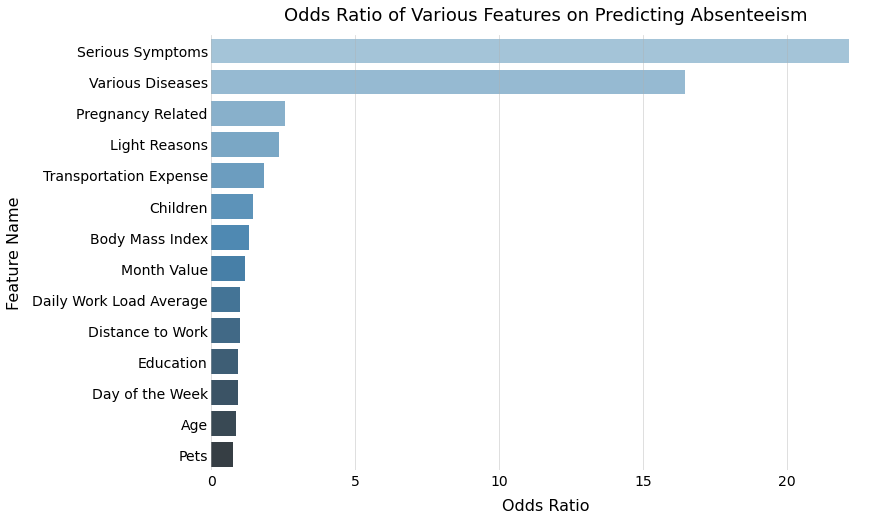

In [51]:
plt.figure(figsize=(12, 8))
ax = plt.gca()

sns.barplot(x='Odds Ratio', y='Feature Name', data=summary_table.sort_values('Odds Ratio', ascending=False)[:-1], palette='Blues_d')

for spine in plt.gca().spines.values():
    spine.set_visible(False)

ax.set_xlabel('Odds Ratio', labelpad=10, fontsize=16)
ax.set_ylabel('Feature Name', labelpad=10, fontsize=16)
ax.set_yticklabels(['Serious Symptoms', 'Various Diseases', 'Pregnancy Related', 'Light Reasons'] 
                   + summary_table['Feature Name'].iloc[4:-1].tolist())
ax.xaxis.set_tick_params(length=0, labelsize=14)
ax.yaxis.set_tick_params(length=0, labelsize=14)
plt.grid(axis='x', alpha=0.5)
ax.set_title('Odds Ratio of Various Features on Predicting Absenteeism', fontsize=18, pad=15)

# plt.savefig('feature_odds_ratios.png', bbox_inches='tight', facecolor='w', dpi=200)
# plt.savefig('feature_odds_ratios.png', bbox_inches='tight', facecolor='w', dpi=800)

plt.show()

Reason Categories: 
* 1 = various diseases
* 2 = pregnancy and childbirth
* 3 = poisoning and peculiar symptoms
* 4 = light diseases and appointments

We can see that 'Reason_3', or serious symptoms, has an 'Odds Ratio' of more than 22, suggesting that the model found that serious symptoms are the most important factor in determining absenteeism time, and as a result, it places the greatest weight with 'Reason_3'.  
In fact, a person with serious symptoms is 22 times more likely to be absent than baseline. 
It is also worth noting that 'Reason_1', or various diseases, is just behind serious symptoms and that there is a steep drop off in terms of importance after reasons 3 and 1.  
With that, it's interesting to note that pregnancy and childbirth are a significant factor in absenteeism time, but not nearly as important as reasons 3 and 1. 

Also, the features closest to 1 have little importance in contributing to absenteeism time, namely 'Daily Work Load Average' and 'Distance to Work'.  
Because these features have little to no contribution to the model, we can simply remove them and rerun our analysis.

In [43]:
df_targets = df.drop(columns=['Absenteeism Time in Hours', 'Daily Work Load Average', 'Distance to Work'])
unscaled_inputs = df_targets.iloc[:, :-1]
columns_to_scale = unscaled_inputs.columns.values.tolist()[4:]
absenteeism_scaler = CustomScaler(columns=columns_to_scale)
absenteeism_scaler.fit(X=unscaled_inputs)
scaled_inputs = absenteeism_scaler.transform(unscaled_inputs)
x_train, x_test, y_train, y_test = train_test_split(scaled_inputs, df_targets['Excessive Absenteeism'], 
                                                    random_state=20, test_size=0.2, shuffle=True)
reg = LogisticRegression()
reg.fit(x_train, y_train)
reg.score(x_train, y_train)

0.775

We can see that even with the features removed, the model still has an accuracy of just about 78%. 

### Testing the Model:

We can now test our model on a dataset which the model has not seen before in order to see how well it can predict absenteeism. 

In [44]:
reg.score(x_test, y_test)

0.7428571428571429

On a dataset which the model has never seen before, the accuracy is a bit lower at 74%. This is expected because the model has not seen the data before, though this would also suggest some slight overfitting.  
(Interesting to note: using a random_state of 42 will actually lead to a higher score on the test dataset than on the training dataset)

We can also take a look at the probability of a test case being 0 or 1. 

In [45]:
predicted_proba = reg.predict_proba(x_test)[:, 1]

In [46]:
predicted_proba.shape

(140,)

In [47]:
predicted_proba

array([0.26367909, 0.39149324, 0.5884953 , 0.19671372, 0.92765949,
       0.68345039, 0.68723089, 0.86641153, 0.20240577, 0.24935512,
       0.51911681, 0.80193717, 0.92240122, 0.28949547, 0.69333066,
       0.42477134, 0.45983343, 0.4290204 , 0.6181567 , 0.95157016,
       0.30177841, 0.20594963, 0.6042142 , 0.57643674, 0.73389594,
       0.24345908, 0.48592848, 0.13125846, 0.80038474, 0.21550284,
       0.37375033, 0.68684805, 0.69151994, 0.54277312, 0.20594963,
       0.50746974, 0.21018312, 0.74373493, 0.4356573 , 0.59258079,
       0.22711399, 0.43398533, 0.2164863 , 0.39622346, 0.81535451,
       0.57004267, 0.69138205, 0.2749828 , 0.2022134 , 0.18213206,
       0.59189934, 0.34261348, 0.67089321, 0.28594573, 0.85012682,
       0.47097096, 0.89014512, 0.25485723, 0.31801378, 0.31586127,
       0.71934353, 0.6603208 , 0.31049764, 0.78742011, 0.19826672,
       0.26755806, 0.08241193, 0.22989059, 0.72823181, 0.33008041,
       0.21018312, 0.29414363, 0.90843346, 0.43755924, 0.61945

The logitic regression model calculates these values in the background, a probability < 0.5 is considered 0, and a probability > 0.5 is considered 1.

Now that we have a model, we can save it so that we can use it on new data later on. 

In [48]:
with open('model.pkl', 'wb') as f:
    pickle.dump(reg, f)

In [49]:
with open('scaler.pkl', 'wb') as f:
    pickle.dump(absenteeism_scaler, f)

And with that, we now have a model that can predict absenteeism time for new individuals. We can now take this model to predict absenteeism time for new individuals and then analyze the new data.  

At this point, we will create a module that will perform many of the preprocessing tasks that we have done in notebook 1 and also some aspects of this notebook so that we can apply it to new data. 